# <center> Oriani Luca

[You can find the original paper here](https://arxiv.org/pdf/1602.01783.pdf).

## Introduction

In this tutorial we will focus on Deep Reinforcement Learning with **REINFORCE**. This tutorial is composed of:
* An introduction to the deep learning framework: **PyTorch**
* A quick reminder of the RL setting,
* A theoritical and coding approch of Reinforce

### Table of contents
[I. Introduction to PyTorch](#partI)<br>
[II. Reinforcement Learning setting](#partII)<br>
[III. Implementation of REINFORCE](#partIII)<br>

# I. Introduction to PyTorch <a id='partI'></a>

*If you already know PyTorch you can skip this part. From this part on we assume that you have some experience with Python and Numpy. This part is extracted from PyTorch docs.*

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |



**AUTOMATIC DIFFERENTIATION**

The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.

# II. Reminder of the RL setting <a id='partII'></a>

As always we will consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ with:
* $\mathcal{S}$ the state space,
* $\mathcal{A}$ the action space,
* $p(x^\prime \mid x, a)$ the transition probability,
* $r(x, a, x^\prime)$ the reward of the transition $(x, a, x^\prime)$,
* $\gamma \in [0,1)$ is the discount factor.

A policy $\pi$ is a mapping from the state space $\mathcal{S}$ to the probability of selecting each action.

The action value function of a policy is the overall expected reward from a state action. $Q^\pi(s, a) = \mathbb{E}_{\tau \sim \pi}\big[R(\tau) \mid s_0=s, a_0=a\big]$ where $\tau$ is an episode $(s_0, a_0, r_0, s_1, a_1, r_1, s_2, ..., s_T, a_T, r_T)$ with the actions drawn from $\pi(s)$; $R(\tau)$ is the random variable defined as the cumulative sum of the discounted reward.

The goal is to maximize the agent's reward.

$$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[R(\tau) \big]$$


## Gym Environment

In this lab and also the next one we are going to use the [OpenAI's Gym library](https://gymnasium.farama.org/api/env/). This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

### **Section 1: Exploring the CartPole Environment with Gymnasium**


**Setup: Install the required packages**

In [ ]:
# Run this cell to install necessary packages
!pip install numpy matplotlib gymnasium==0.28.1 imageio ffmpeg pillow

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.4 MB/s eta 0:00:00
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=3292d36190c0c9f739d5e2a5e2501eb8e6531323d3759185c07f5483553b6137
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


#### Import Libraries

In [ ]:
import base64
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path

import imageio
from PIL import Image
import IPython.display as ipythondisplay

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

**Tool: Display Video of Environment Interactions**

This function displays recorded videos of the environment, allowing us to visualize how different actions affect the CartPole environment.

In [ ]:
# Define a directory to save the videos
video_dir = Path("./video")
video_dir.mkdir(exist_ok=True)

# Define target width and height for video frames to avoid resizing warnings
target_width, target_height = 608, 400

def record_video(env_name, video_name, policy_func, steps=10):
    """
    Records a video of the environment following a specified policy.

    Parameters:
    - env_name (str): Name of the environment.
    - video_name (str): Name for the output video file.
    - policy_func (function): A function that defines the policy (action selection).
    - steps (int): Number of steps to record.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    state, _ = env.reset()
    video_path = video_dir / f"{video_name}.mp4"
    writer = imageio.get_writer(video_path, fps=30)

    for t in range(steps):
        action = policy_func(env)  # Get action from the policy function
        state, reward, done, truncated, _ = env.step(action)

        # Capture and resize the frame
        frame = env.render()
        resized_frame = np.array(Image.fromarray(frame).resize((target_width, target_height)))
        writer.append_data(resized_frame)

        if done or truncated:
            break

    writer.close()
    env.close()

def show_video(directory):
    """
    Display all .mp4 video files from the specified directory in the notebook.
    """
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(f'''<video alt="{mp4}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
                 </video>''')
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

#### **Question 1**: Initialize the *CartPole-v1* environment using *gymnasium*. Print the observation space and action space, reset the environment, and print the initial observation.

**Solution**

In [ ]:
# Initialize CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action spaces
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

# Reset environment and print initial observation
observation, info = env.reset()
print("Initial Observation:", observation)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)
Initial Observation: [ 0.04803439  0.00930212 -0.03500086 -0.00886625]


#### **Question 2:** Do the same for the following environments: *Acrobot-v1* and *MountainCar-v0*. For each environment, initialize it, print the observation and action space, reset it, and display the initial observation.

In [ ]:
# Solution for Acrobot
env_acrobot = gym.make("Acrobot-v1")
print("Acrobot-v1 Observation Space:", env_acrobot.observation_space)
print("Acrobot-v1 Action Space:", env_acrobot.action_space)
observation_acrobot, info_acrobot = env_acrobot.reset()
print("Acrobot-v1 Initial Observation:", observation_acrobot)

# Solution for MountainCar
env_mountaincar = gym.make("MountainCar-v0")
print("MountainCar-v0 Observation Space:", env_mountaincar.observation_space)
print("MountainCar-v0 Action Space:", env_mountaincar.action_space)
observation_mountaincar, info_mountaincar = env_mountaincar.reset()
print("MountainCar-v0 Initial Observation:", observation_mountaincar)

Acrobot-v1 Observation Space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Acrobot-v1 Action Space: Discrete(3)
Acrobot-v1 Initial Observation: [ 0.99960756 -0.02801247  0.9978014   0.06627482 -0.07648531 -0.02614411]
MountainCar-v0 Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
MountainCar-v0 Action Space: Discrete(3)
MountainCar-v0 Initial Observation: [-0.59175295  0.        ]


#### **Question 3:** Describe the objective of each environment (CartPole, Acrobot, MountainCar). For each environment, specify the roles of observations, actions, and rewards.

#### **Solution:**

CartPole-v1

Objective: Balance a pole on a moving cart for as long as possible. The goal is to prevent the pole from falling over or the cart from moving out of bounds.

    Observations: A 4-dimensional vector:
        Cart position.
        Cart velocity.
        Pole angle.
        Pole angular velocity. These values help determine the state of the system for controlling the pole.

    Actions:
        Discrete(2): Two possible actions:
            Push the cart to the left.
            Push the cart to the right.

    Rewards:
        +1 reward for every time step the pole remains upright.
        The episode terminates if:
            The pole angle exceeds ±12 degrees.
            The cart position exceeds ±2.4 units.
            The pole remains balanced for 500 time steps (success).

Acrobot-v1

Objective: Swing the bottom link of a two-link robotic arm upward to reach a specific height. The agent must use the dynamics of the arm to achieve this goal.

    Observations: A 6-dimensional vector:
        Cosine of the angle of the first joint.
        Sine of the angle of the first joint.
        Cosine of the angle of the second joint.
        Sine of the angle of the second joint.
        Angular velocity of the first joint.
        Angular velocity of the second joint. These values describe the configuration and motion of the two-link arm.

    Actions:
        Discrete(3): Three possible actions:
            Apply torque to the first joint in the negative direction.
            Apply torque to the first joint in the positive direction.
            Apply no torque.

    Rewards:
        A reward of -1 for every time step until the goal is reached.
        The episode terminates when the tip of the arm reaches a height greater than the predefined target (indicating success) or after 500 time steps (failure).

MountainCar-v0

Objective: Drive a car up a steep hill to reach the goal. The car does not have enough power to directly reach the goal, so it must build momentum by oscillating between hills.

    Observations: A 2-dimensional vector:
        Car position along the track.
        Car velocity. These values describe the car’s state and help determine how much momentum is needed.

    Actions:
        Discrete(3): Three possible actions:
            Accelerate left.
            Accelerate right.
            Do nothing.

    Rewards:
        A reward of -1 for each time step until the car reaches the goal.
        The episode terminates when:
            The car reaches a position greater than or equal to 0.5 (goal reached).
            The episode reaches a maximum of 200 time steps (failure).

#### **Question 4:** Run a random policy for 10 steps in each environment (CartPole, Acrobot, MountainCar), record the interactions as videos, and display them. Use the show_video function to visualize the results.

#### **Solution**

In [ ]:
# Define a random policy
def random_policy(env):
    # Choose a random action
    return env.action_space.sample()

In [ ]:
# Record video for each environment with random policy
record_video("CartPole-v1", "random_policy_cartpole", random_policy, steps=10)
record_video("Acrobot-v1", "random_policy_acrobot", random_policy, steps=10)
record_video("MountainCar-v0", "random_policy_mountaincar", random_policy, steps=10)

In [ ]:
# Display recorded videos
show_video(video_dir)

#### **Question 5:**  What are the differences between discrete and continuous action spaces in reinforcement learning? Identify whether the CartPole, Acrobot, and MountainCar environments have discrete or continuous action spaces.

#### **Solution:**

With a discrete action space actions are selected from a finite set of distinct choices. With a continuous action space actions are selected from a continuous range of values.

All three environments (CartPole, Acrobot, MountainCar) have discrete action spaces, where the agent selects actions from a finite set of choices.

#### **Question 6:** Implement a simple constant policy (always choosing the same action) for each environment (CartPole, Acrobot, MountainCar). Run this policy for 10 steps, record the videos, and compare the results.

In [ ]:
# Define a constant policy function that takes the environment as input
def constant_policy(action):
    # Returns a function that takes the environment and always returns the same action
    def policy(env):
        return action
    return policy

In [ ]:
# Record video for CartPole with a constant policy (e.g., always move right)
record_video("CartPole-v1", "constant_right_policy_cartpole", constant_policy(1), steps=10)

# Record video for Acrobot with a constant policy (e.g., always apply a fixed torque)
record_video("Acrobot-v1", "constant_torque_policy_acrobot", constant_policy(1), steps=10)

# Record video for MountainCar with a constant policy (e.g., always move right)
record_video("MountainCar-v0", "constant_forward_policy_mountaincar", constant_policy(2), steps=10)

In [ ]:
# Display recorded videos of constant policy interactions
show_video(video_dir)

# III. Implementation of REINFORCE  <a id='partIII'></a>

### Introduction

Reinforce is an actor-based **on policy** method. The policy $\pi_{\theta}$ is parametrized by a function approximator (e.g. a neural network).

Recall: $$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[ \sum_{t} \gamma^t R_t \mid x_0, \pi \big].$$

To update the parameters $\theta$ of the policy, one has to do gradient ascent: $\theta_{k+1} = \theta_{k} + \alpha \nabla_{\theta}J(\pi_{\theta})|_{\theta_{k}}$.

**Advantages of this approach:**
- Compared to a Q-learning approach, here the policy is directly parametrized so a small change of the parameters will not dramatically change the policy whereas this is not the case for Q-learning approaches.
- The stochasticity of the policy allows exploration. In off policy learning, one has to deal with both a behaviour policy and an exploration policy.

### Policy Gradient Theorem

#### **Question 7: Prove the Policy Gradient Theorem:** $$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)}\right]$$


The policy gradient can be approximated with:
$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) $$

#### Hint 1

The probability of a trajectory $\tau = (s_{0}, a_{0},\dots, s_{T+1}$) with action chosen from $\displaystyle \pi_{\theta}$ is $P(\tau|\theta) = \rho_{0}(s_{0})\prod_{t=0}^{T}P\left(s_{t+1}|s_{t}, a_{t}\right) \pi_{\theta}(a_{t}|s_{t})$

#### Hint 2

Gradient-log trick: $  \nabla_{\theta}P(\tau|\theta)= P(\tau|\theta)\nabla_{\theta}\log P(\tau|\theta). $

The policy gradient can therefore be approximated with:
$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) $$

#### **Solution**:

The **Policy Gradient Theorem** states that:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) Q^{\pi_\theta}(s_t, a_t) \right]
$$

where $J(\pi_\theta)$ is the expected cumulative reward under the policy $\pi_\theta$.

---

#### Step 1: Define the Objective Function

The objective function $J(\pi_\theta)$ is defined as:

$$
J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \gamma^t R(s_t, a_t) \right]
$$

Here, $\tau = (s_0, a_0, s_1, a_1, \ldots)$ is a trajectory sampled from the policy $\pi_\theta$, and $R(s_t, a_t)$ is the reward received at time $t$.

---

#### Step 2: Rewrite the Expectation Using the Probability of a Trajectory

The expectation over trajectories can be rewritten as:

$$
J(\pi_\theta) = \int_\tau P_\theta(\tau) \sum_{t=0}^T \gamma^t R(s_t, a_t) d\tau
$$

where $P_\theta(\tau)$ is the probability of the trajectory $\tau$ under policy $\pi_\theta$, defined as:

$$
P_\theta(\tau) = p(s_0) \prod_{t=0}^T \pi_\theta(a_t | s_t) p(s_{t+1} | s_t, a_t)
$$

---

#### Step 3: Compute the Gradient of $J(\pi_\theta)$

Taking the gradient of $J(\pi_\theta)$ with respect to $\theta$:

$$
\nabla_\theta J(\pi_\theta) = \nabla_\theta \int_\tau P_\theta(\tau) \sum_{t=0}^T \gamma^t R(s_t, a_t) d\tau
$$

Using the *log-derivative trick*, $\nabla_\theta P_\theta(\tau) = P_\theta(\tau) \nabla_\theta \log P_\theta(\tau)$, we get:

$$
\nabla_\theta J(\pi_\theta) = \int_\tau P_\theta(\tau) \nabla_\theta \log P_\theta(\tau) \sum_{t=0}^T \gamma^t R(s_t, a_t) d\tau
$$

Rewriting the expectation:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \nabla_\theta \log P_\theta(\tau) \sum_{t=0}^T \gamma^t R(s_t, a_t) \right]
$$

---

#### Step 4: Expand $\log P_\theta(\tau)$

The log-probability of a trajectory is:

$$
\log P_\theta(\tau) = \sum_{t=0}^T \log \pi_\theta(a_t | s_t) + \sum_{t=0}^T \log p(s_{t+1} | s_t, a_t)
$$

The environment dynamics $p(s_{t+1} | s_t, a_t)$ are independent of $\theta$, so their gradients vanish:

$$
\nabla_\theta \log P_\theta(\tau) = \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t)
$$

---

#### Step 5: Substitute Back Into the Gradient

Substituting $\nabla_\theta \log P_\theta(\tau)$ into the gradient expression:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) \sum_{t'=0}^T \gamma^{t'} R(s_{t'}, a_{t'}) \right]
$$

Reorganizing terms:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) Q^{\pi_\theta}(s_t, a_t) \right]
$$

where $Q^{\pi_\theta}(s_t, a_t)$ is the expected cumulative reward starting from $(s_t, a_t)$, defined as:

$$
Q^{\pi_\theta}(s_t, a_t) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t'=t}^T \gamma^{t'-t} R(s_{t'}, a_{t'}) \right]
$$

---

### Conclusion

This completes the proof of the **Policy Gradient Theorem**:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) Q^{\pi_\theta}(s_t, a_t) \right]
$$

### **Implementation of vanilla REINFORCE**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure.


#### **Question 8:**

You will need to
- code the method `_make_returns`.
- code the method `optimize_model`.

#### Model Class

In [ ]:
# Model class to define the neural network
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()

        self.n_actions = n_actions
        self.dim_observation = dim_observation

        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )

    def forward(self, state):
        """Forward pass through the network"""
        return self.net(state)

    def select_action(self, state):
        """Select action based on the policy (output of the network)"""
        probs = self.forward(state)
        # Sample action from distribution
        action = torch.multinomial(probs, 1)
        return action

#### Base Agent Class

In [ ]:
# Base Agent class
class BaseAgent:
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'],render_mode="rgb_array")
        # Set random seed for reproducibility
        self.env.reset(seed=config['seed'])
        torch.manual_seed(config['seed'])
        np.random.seed(config['seed'])
        # the model for the agent policy
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma'] # the discount factor
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        # Use RecordVideo for recording the environment's gameplay
        self.video_folder = "./gym-results/" + config['video_folder_name']
        self.monitor_env = RecordVideo(self.env, self.video_folder, episode_trigger=lambda episode: True)

    # Method to implement
    ## Code this function
    def _make_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step"""
        raise NotImplementedError

    # Method to implement
    ## Code this function
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories
        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        raise NotImplementedError

    def train(self, n_trajectories, n_update):
        """Training method"""
        rewards = []
        # loop over n_updates
        for episode in range(n_update):
            # optimize the model and store the rewards
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, errorbar='sd');

    def evaluate(self):
        """Evaluate the agent on a single trajectory"""
        observation, _ = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            # select action based on agent policy
            action = self.model.select_action(observation)
            observation, reward, done, _, _ = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            # save reward
            reward_episode += reward

        self.monitor_env.close()
        show_video(self.video_folder)
        print(f'Reward: {reward_episode}')

#### Simple Agent

In [ ]:
class SimpleAgent(BaseAgent):
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories"""
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)
        for i in range(n_trajectories):

            # New episode
            observation, _ = self.env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1
            observation = torch.tensor(observation, dtype=torch.float)
            done = False


            while not done:
                action = self.model.select_action(observation)
                logproba_episode.append(torch.log(self.model(observation))[action])

                # Interaction with the environment
                observation, reward, done, _, _ = self.env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                rewards_episode.append(discount_factor * reward)
                discount_factor *= self.gamma

            # Calculate the cumulative reward
            cum_rewards_episode = np.sum(rewards_episode)

            # Sum the log-probabilities of the selected actions in this episode
            logproba_sum = torch.sum(torch.stack(logproba_episode))

            # Update weighted log probabilities
            weighted_logproba[i] = cum_rewards_episode * logproba_sum
            reward_trajectories[i] = cum_rewards_episode

        # Compute the loss (negative log-likelihood weighted by the reward)
        loss = - weighted_logproba.mean()
        self.optimizer.zero_grad()
        loss.backward() # Compute the gradients
        self.optimizer.step() # Take a step using the gradients
        return reward_trajectories


In [ ]:
#@title Config {display-mode: "form", run: "auto"}

env_id = 'CartPole-v1'  #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0"]
learning_rate = 0.01  #@param {type: "number"}
gamma = 0.99  #@param {type: "number"}
seed = 1235  #@param {type: "integer"}
#@markdown ---

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
print(config)


Current config is:
{'env_id': 'CartPole-v1', 'learning_rate': 0.01, 'seed': 1235, 'gamma': 0.99}


In [ ]:
config['video_folder_name'] = "simple_agent"

#### Train Simple Agent

Episode 1/10: rewards 16.71 +/- 6.35
Episode 2/10: rewards 20.84 +/- 10.94
Episode 3/10: rewards 15.3 +/- 4.95
Episode 4/10: rewards 16.48 +/- 9.36
Episode 5/10: rewards 19.44 +/- 6.12
Episode 6/10: rewards 20.29 +/- 5.44
Episode 7/10: rewards 19.05 +/- 7.72
Episode 8/10: rewards 15.64 +/- 11.35
Episode 9/10: rewards 23.69 +/- 11.87
Episode 10/10: rewards 19.58 +/- 8.61


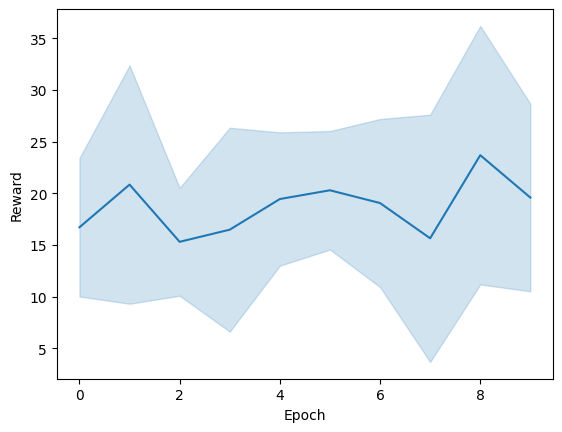

In [ ]:
# Initialize the agent
agent = SimpleAgent(config)
# Train the agent
agent.train(n_trajectories=10, n_update=10)

In [ ]:
# Evaluate the agent after training
agent.evaluate()

Moviepy - Building video /content/gym-results/simple_agent/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym-results/simple_agent/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/simple_agent/rl-video-episode-0.mp4


Reward: 33.0


#### **Don't let the past distract you!**

- The sum of rewards during one episode has a high variance which affects the performance of this version of **REINFORCE**.
- To assess the quality of an action, it make more sense to take into consideration only the rewards obtained after taking this action.
- It can be proven that $$  \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \sum_{t'=t}^T \gamma^{t'-t} R(s_{t'}, a_{t'}, s_{t'+1})}\right].$$
- **Bonus**: proof of this claim.
- This has for effect to reduce the variance. Past rewards have zero mean but nonzero variance so they just add noise.  

In [ ]:
class EnhancedAgent(BaseAgent):
    def select_action(self, state):
        """Select action based on the policy (output of the network)"""
        probs = self.model(state)
        # Sample action from distribution
        action = torch.multinomial(probs, 1).item() # Get the action as an integer
        logproba = torch.log(probs[action]) # Get the log probability of the selected action
        return action, logproba

    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories"""
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)

        for i in range(n_trajectories):
            # New episode
            observation, _ = self.env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1.0
            observation = torch.tensor(observation, dtype=torch.float)
            terminated = False
            truncated = False

            # Interact with the environment
            while not terminated and not truncated:
                # Take an action and save log probability
                action, logproba = self.select_action(observation)  # Assuming this method exists
                next_observation, reward, terminated, truncated, _ = self.env.step(action)  # Updated to unpack 5 values
                rewards_episode.append(reward)
                logproba_episode.append(logproba)

                # Prepare for the next step
                observation = torch.tensor(next_observation, dtype=torch.float)

            # Calculate the cumulative reward for the trajectory
            cumulative_rewards = []
            g = 0
            for r in reversed(rewards_episode):
                g = r + self.gamma * g
                cumulative_rewards.insert(0, g)  # Insert at the beginning to reverse the list

            # Normalize cumulative rewards for variance reduction
            cumulative_rewards = torch.tensor(cumulative_rewards, dtype=torch.float)
            cumulative_rewards = (cumulative_rewards - cumulative_rewards.mean()) / (
                cumulative_rewards.std() + 1e-8
            )

            # Sum the log-probabilities of the selected actions in this episode
            logproba_episode = torch.stack(logproba_episode)  # Convert to a single tensor
            weighted_logproba[i] = (logproba_episode * cumulative_rewards).sum()

            # Store the total reward for tracking
            reward_trajectories[i] = sum(rewards_episode)

        # Compute the loss (negative log-likelihood weighted by the reward)
        loss = -weighted_logproba.mean()
        self.optimizer.zero_grad()
        loss.backward()  # Compute the gradients
        self.optimizer.step()  # Take a step using the gradients

        return reward_trajectories

In [ ]:
#@title Config Enhanced {display-mode: "form", run: "auto"}

env_id = 'CartPole-v1'  #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v1"]
learning_rate = 0.03  #@param {type: "number"}
gamma = 0.99  #@param {type: "number"}
seed = 1  #@param {type: "integer"}
#@markdown ---

config_enhanced = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config_enhanced is:")
print(config_enhanced)

Current config_enhanced is:
{'env_id': 'CartPole-v1', 'learning_rate': 0.03, 'seed': 1, 'gamma': 0.99}


### Train Enhanced Agent

In [ ]:
config_enhanced['video_folder_name'] = "enhanced_agent"

In [ ]:
agent = EnhancedAgent(config_enhanced)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/gym-results/enhanced_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/30: rewards 18.7 +/- 4.63
Episode 2/30: rewards 29.0 +/- 18.77
Episode 3/30: rewards 16.6 +/- 7.12
Episode 4/30: rewards 24.6 +/- 11.38
Episode 5/30: rewards 19.4 +/- 13.13
Episode 6/30: rewards 23.9 +/- 5.24
Episode 7/30: rewards 30.1 +/- 12.45
Episode 8/30: rewards 36.0 +/- 23.44
Episode 9/30: rewards 29.2 +/- 13.57
Episode 10/30: rewards 33.1 +/- 13.49
Episode 11/30: rewards 45.0 +/- 22.88
Episode 12/30: rewards 38.0 +/- 17.22
Episode 13/30: rewards 80.2 +/- 27.52
Episode 14/30: rewards 94.4 +/- 50.58
Episode 15/30: rewards 91.5 +/- 40.22
Episode 16/30: rewards 91.5 +/- 32.23
Episode 17/30: rewards 107.4 +/- 53.4
Episode 18/30: rewards 147.4 +/- 76.68
Episode 19/30: rewards 128.6 +/- 44.53
Episode 20/30: rewards 194.7 +/- 86.14
Episode 21/30: rewards 232.0 +/- 45.91
Episode 22/30: rewards 161.0 +/- 22.57
Episode 23/30: rewards 140.1 +/- 14.58
Episode 24/30: rewards 134.6 +/- 9.39
Episode 25/30: rewards 118.8 +/- 6.65
Episode 26/30: rewards 99.5 +/- 30.33
Episode 27/30: rew

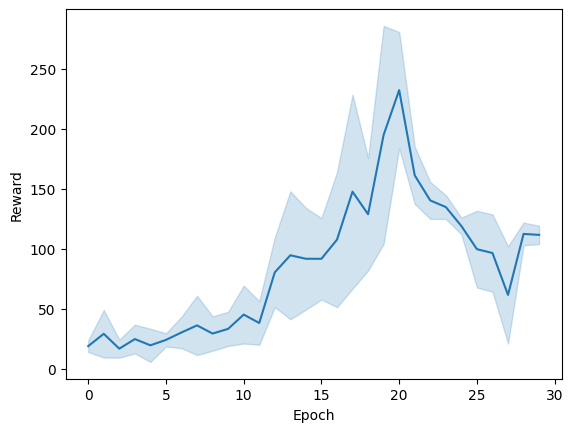

In [ ]:
agent.train(n_trajectories=10, n_update=30)

In [ ]:
agent.evaluate()

Moviepy - Building video /content/gym-results/enhanced_agent/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym-results/enhanced_agent/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/enhanced_agent/rl-video-episode-0.mp4


Reward: 100.0
